In [ ]:
#@title [RUN] Install required python libraries
import os

# Install PyTorch Geometric and other libraries
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
#     !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
#     !pip install -q torch-geometric==2.0.3
#     !pip install -q rdkit-pypi==2021.9.4
#     !pip install -q py3Dmol==1.8.0
!jupyter nbextension enable --py widgetsnbextension

In [1]:
#@title [RUN] Import python modules

import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

import subprocess
import random
import math
import re
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter
from pathlib import Path
# import rdkit.Chem as Chem
# from rdkit.Geometry.rdGeometry import Point3D
# from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
# from rdkit.Chem.Draw import IPythonConsole

# import py3Dmol
# from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#from google.colab import files
from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

#   set the display width
#display(HTML("<style>.container { width:80% !important; }</style>"))


PyTorch version 2.3.1
PyG version 2.5.3


In [2]:
####  list_files

In [3]:
def list_files(directory, caller):


    print(' called from ', caller, '\n  List files in ',directory)
    # List files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    print(' called from ', caller, '\n  List files in ',directory, '\n', files)    
    print(files)

####   read_ev

In [4]:
def read_ev(dfile):
    """
    read event from the data file
    """
    print ('read events from file ',dfile)

    # Regular expression to remove ANSI escape codes
    dfile = re.sub(r'\x1b\[[0-9;]*m', '', dfile)


    table = np.loadtxt(dfile)

    return table

def get_nodes(table, n_req=5, dist_cut=1.0 ):
    
    """
    get the node data: list of nodes and their atributes, adjacency matrix
    """
    vtrk_x = table[:,1]
    vtrk_y = table[:,2]
    vtrk_z = table[:,3]
    vtrk_E = table[:,4]
    
    length = len(vtrk_x)

    n_nodes = min(n_req,length)
    
    #   convert to the n array of he requested length
    
    vtrk_x = np.array(vtrk_x[:n_nodes])
    vtrk_y = np.array(vtrk_y[:n_nodes])
    vtrk_z = np.array(vtrk_z[:n_nodes])
    vtrk_E = np.array(vtrk_E[:n_nodes])

    
    vtrk_ID = np.arange(n_nodes)
    
    #    for some reason it was necessary to make sure that the x values are never identical
    for ID in vtrk_ID:
        vtrk_x[ID] = vtrk_x[ID] + (ID * 10e-5)
            
    
    # ---------------------------------------------------------------------------
    # Create the adjacency matrix
    # -1 --> self
    # 0 --> not a neighbor
    # (distance) --> nodes are neighbors
    # ---------------------------------------------------------------------------
     
    # Iterate through all nodes, and for each one find the neighboring nodes.
    adjMat = []; nnbrMat = []
    
    for vID1,vx1,vy1,vz1,vE1 in zip(vtrk_ID,vtrk_x,vtrk_y,vtrk_z,vtrk_E):
        nbr_list = [];
        nnbrs = 0;
        for vID2,vx2,vy2,vz2,vE2 in zip(vtrk_ID,vtrk_x,vtrk_y,vtrk_z,vtrk_E):  
            if(vx1 == vx2 and vy1 == vy2 and vz1 == vz2):
                nbr_list.append(1.e6);
            else:
                # proximity cut: accept liks shorter than dist_cut
                dist = math.sqrt((vx2-vx1)**2 + (vy2-vy1)**2 + (vz2-vz1)**2);
                if (dist < dist_cut):
                    #print ('\n nodes ',vID1,vID2, vx1, vy1, vz1, vE1, vx2,vy2,vz2, vE2, vE2/dist)
                    nbr_list.append(dist);
                    nnbrs += 1;
                else:
                    nbr_list.append(1.e6);
        nnbrMat.append(nnbrs);
        adjMat.append(np.array(nbr_list));
    #print (vtrk_E)
    #print (sum(vtrk_E))
    return n_nodes, vtrk_x, vtrk_y, vtrk_z, vtrk_E, np.array(nnbrMat), np.array(adjMat)

def get_events_NEXT():
    

    """
    fetch list of all signal and background events
    """

    ddir_sig   = '/Users/para/GNN_rec/db/data/double_beta/'
    ddir_bckg  = '/Users/para/GNN_rec/db/data/single_electron/'

    # Regular expression to remove ANSI escape codes
    ddir_sig = re.sub(r'\x1b\[[0-9;]*m', '', ddir_sig)
    ddir_bckg = re.sub(r'\x1b\[[0-9;]*m', '', ddir_bckg)

    sig_files = []
    bckg_files = []
    
    sig_files = subprocess.check_output('ls ' + ddir_sig + 'mctru*', shell=True).decode("utf-8").split('\n')
    bckg_files = subprocess.check_output('ls ' + ddir_bckg + 'mctru*', shell=True).decode("utf-8").split('\n')

    return sig_files, bckg_files

def NEXT_data(nev=10, n_points=4, dist_cut=1.0, debug=False):
    
    """
    load nev events, n_points is the maximal number of nodes (for debugging/efficiency)
    dis_cut defines the adjancent limit
    """
    
    
    sig, bckg = get_events_NEXT()

    all_files = sig + bckg
    random.shuffle(all_files)

    events = []
    
    nread = min(nev, len(all_files))
    
    for f in all_files[0:nread]:
        f  = re.sub(r'\x1b\[[0-9;]*m', '', f)   #  remove the escape code (color)

        if len(f) < 10: continue     #   list of files cantain empty lines at the end of the ls output

        if f.find('single') > 0:
            targ = 0                 # background tag
        if f.find('double') > 0:
            targ = 1                 # signal tag

        # print ('  try to read event from file ', f)
        #   # Check file existence and readability

        # dfile = f 
        # file_path = Path(dfile)
        # if file_path.exists():
        #     print(f"File {dfile} exists.")
        #     if os.access(dfile, os.R_OK):
        #         print(f"File {dfile} is readable.")
        #     else:
        #         print(f"File {dfile} is not readable.")
        # else:
        #     print(f"File {dfile} does not exist.")
            
        table =  read_ev(f)   
        n_nodes, vtrk_x, vtrk_y, vtrk_z, vtrk_E, nnbrMat, adjMat = get_nodes(table, n_req=n_points, dist_cut=dist_cut )

        if debug:
            print ('  NEXT_data from file ', f )
            for nn in range(n_nodes):
                print ('x,y,z,E ',vtrk_x[nn],vtrk_y[nn],vtrk_z[nn],vtrk_E[nn])
            print ('AdjMat\n',adjMat)
            print ('number of neighbours ', nnbrMat)

        dlim = 10.
        
        feats = []   #  node features 

        edge_ind = []
        edge_val = []
    
        for nn in range(n_nodes):
            n_neigh = nnbrMat[nn]
#             print ('  node ', nn, n_neigh, ' neighbours')
            av_en   = 0.
            en_dens = 0.
            av_len  = 0.
            
            for mm in range( n_nodes):
                if adjMat[nn,mm] > dlim: continue
                #print ('  link ', nn,mm, vtrk_E[mm], adjMat[nn,mm])
                av_en   += vtrk_E[mm]
                en_dens += vtrk_E[mm]/adjMat[nn,mm] 
                av_len  += adjMat[nn,mm] 
                
                edge_ind.append((nn,mm))
                edge_val.append(adjMat[nn,mm] )
                
            if n_neigh>0:
                
                av_en   = av_en/n_neigh
                av_len  = av_len/n_neigh
                en_dens = en_dens/n_neigh
                
            
            feat = (vtrk_E[nn], n_neigh, av_en, en_dens, av_len)
            feats.append(feat)
            
#             print ('  node ', nn,'   mean energy', av_en, '  en_dens',en_dens, n_neigh)
            pos = np.array([vtrk_x.tolist(), vtrk_y.tolist(), vtrk_z.tolist()])
    
        ev = (targ, pos, feats, edge_ind, edge_val, n_nodes)
        
        events.append(ev)
    
    return events

In [5]:
def NEXT100_events_from_file(f, nev=1, n_points=4, dist_cut=1.0, debug=False, ext='.GNN_inp'):
    
    """
    read a single file.. it contains multiple events
    load nev events, n_points is the maximal number of nodes (for debugging/efficiency)
    dis_cut defines the adjancent limit
    """
    if debug:
        print ('   Fetch events from file ',f)
        
    np.set_printoptions(linewidth=9999999)
    

    
    if f.find('1eroi') > 0:
        targ = 0                 # background tag
    if f.find('0nubb') > 0:
        targ = 1                 # signal tag

    #   read all events from a file
    rd_events = read_events(f, debug=False) 
 
    #   loop over all events 

    events = []
     
    ev_no = 0
    
    for table in rd_events:
        
        if ev_no > nev: continue
        ev_no += 1
        
        n_nodes, vtrk_x, vtrk_y, vtrk_z, vtrk_E, nnbrMat, adjMat = get_nodes_josh(table, n_req=n_points, dist_cut=dist_cut, ecut=4.e-4, plot=False )
    
        if debug:
            print ('  NEXT_data from file ', f )
            for nn in range(n_nodes):
                print ('x,y,z,E ',vtrk_x[nn],vtrk_y[nn],vtrk_z[nn],vtrk_E[nn])
            print ('AdjMat\n',adjMat)
            print ('number of neighbours ', nnbrMat)
    
        dlim = 10.
        
        feats = []   #  node features 
    
        edge_ind = []
        edge_val = []
    
        for nn in range(n_nodes):
            
            nodes = []
            
            n_neigh = nnbrMat[nn]
    #             print ('  node ', nn, n_neigh, ' neighbours')
            av_en   = 0.
            en_dens = 0.
            av_len  = 0.
            
            for mm in range( n_nodes):
                if adjMat[nn,mm] > dlim: continue
                #print ('  link ', nn,mm, vtrk_E[mm], adjMat[nn,mm])
                
                av_en   += vtrk_E[mm]
                en_dens += vtrk_E[mm]/adjMat[nn,mm] 
                av_len  += adjMat[nn,mm] 
                
                edge_ind.append((nn,mm))
                edge_val.append(adjMat[nn,mm] )
                
            if n_neigh>0:
                
                av_en   = av_en/n_neigh
                av_len  = av_len/n_neigh
                en_dens = en_dens/n_neigh
                
            
            feat = (vtrk_E[nn], n_neigh, av_en, en_dens, av_len)
            feats.append(feat)
            
    #             print ('  node ', nn,'   mean energy', av_en, '  en_dens',en_dens, n_neigh)
            pos = np.array([vtrk_x.tolist(), vtrk_y.tolist(), vtrk_z.tolist()])
    
            node = (targ, pos, feats, edge_ind, edge_val, n_nodes)
            nodes.append(node)
            
        events.append(nodes)
        
        
           
    return events



def get_nodes_josh(table, n_req=5, dist_cut=10.0 , ecut=4.e-4, debug=False, plot=False):
    
    """
    get the node data: list of nodes and their atributes, adjacency matrix
    """
    if debug:
        print ('---->   get nodes, the input table check ')
        print (type(table))
        print ('  nodes ', table.shape)
    tableT = table.T
    
    x = tableT[0]
    y = tableT[1]
    z = tableT[2]
    E = tableT[3]
 
    if plot: 
        #   analyze the spectrum of nodes to optimize the energy cutoff
        sns.histplot(data=E , color="red", bins=100, cumulative=True)  
        plt.show()
        
    vtrk_x, vtrk_y, vtrk_z, vtrk_E = [], [], [], []

    for xx,yy,zz,ee in zip(x,y,z,E):
        
         if ee < ecut: continue        #  eliminate low signal nodes
    
         vtrk_x.append(xx)
         vtrk_y.append(yy)
         vtrk_z.append(zz)
         vtrk_E.append(ee)
 
    length = len(vtrk_x)
    n_nodes = min(n_req,length)             #   for debugging purposes save fewer nodes     
    vtrk_ID = np.arange(n_nodes)

    
    #   convert to the n array of he requested length
    
    vtrk_x = np.array(vtrk_x[:n_nodes])
    vtrk_y = np.array(vtrk_y[:n_nodes])
    vtrk_z = np.array(vtrk_z[:n_nodes])
    vtrk_E = np.array(vtrk_E[:n_nodes])


    vtrk_ID = np.arange(n_nodes)
    
    #    for some reason it was necessary to make sure that the x values are never identical
    for ID in vtrk_ID:
        vtrk_x[ID] = vtrk_x[ID] + (ID * 10e-5)
            
    
    # ---------------------------------------------------------------------------
    # Create the adjacency matrix
    # -1 --> self
    # 0 --> not a neighbor
    # (distance) --> nodes are neighbors
    # ---------------------------------------------------------------------------
     
    # Iterate through all nodes, and for each one find the neighboring nodes.
    adjMat = []; nnbrMat = []
    
    for vID1,vx1,vy1,vz1,vE1 in zip(vtrk_ID,vtrk_x,vtrk_y,vtrk_z,vtrk_E):
        nbr_list = [];
        nnbrs = 0;
        for vID2,vx2,vy2,vz2,vE2 in zip(vtrk_ID,vtrk_x,vtrk_y,vtrk_z,vtrk_E):  
            if(vx1 == vx2 and vy1 == vy2 and vz1 == vz2):
                nbr_list.append(1.e6);
            else:
                # proximity cut: accept liks shorter than dist_cut
                dist = math.sqrt((vx2-vx1)**2 + (vy2-vy1)**2 + (vz2-vz1)**2);
                if (dist < dist_cut):
                    #print ('\n nodes ',vID1,vID2, vx1, vy1, vz1, vE1, vx2,vy2,vz2, vE2, vE2/dist)
                    nbr_list.append(dist);
                    nnbrs += 1;
                else:
                    nbr_list.append(1.e6);
        nnbrMat.append(nnbrs);
        adjMat.append(np.array(nbr_list));

    return n_nodes, vtrk_x, vtrk_y, vtrk_z, vtrk_E, np.array(nnbrMat), np.array(adjMat)

def read_events(dfile, debug=False):
    """
    read events from the data file
    """
    
    events = []
    f = open(dfile)
    linea = f.readlines()  
    f.close()

    table = np.loadtxt(dfile,comments='E')

    if debug:
        print ('  file ',dfile, '\n', '  number of lines ',len(linea))
    #   identify the event header
    
    ev_head = []

    lin_no = -1
    
    for lin in linea:
        lin_no += 1
        if lin.find('Ev') > -1:
            ev_head.append(lin_no)

    n_events = len(ev_head) 
    

    if debug:     
        print (' number of events  ',n_events)
        for beg in ev_head:
            print (' event header', linea[beg])

    ev_head.append(len(linea))  # end of the last event
    
    for iev in range(n_events):
        
        len_ev = ev_head[iev+1] - ev_head[iev] -1
        
        jbeg =  ev_head[iev] - iev
        jend =  ev_head[iev] + len_ev - iev - 1    #   poinsta numberng starts at 'local 0'

        event = table[jbeg:jend+1]
        events.append(event)        
        
        if debug:
            print ( 'jbeg, jend ',jbeg, jend)
            print ('  event no', iev, '  length ', len_ev )
            print ('   first point ',table[jbeg])
            print ('   last point ',table[jend])
        
            for linn in range(jend-3, jend+5):
                print ('  line ', linn, '  ', linea[linn].rstrip())
    
            for linn in range(jend-3, jend+1):
    
               print ('  table[linn-iev] ', linn-iev, '   ', table[linn-iev])        

    
    return events


#### make list of available files
Files are in the directory /home/para/GNN_loc/NEXT100_data/(1eroi)(0nubb)/beersheba
0unubb have 50 ev, 1eroi have 200 events
(at the moment only 111 signal files are copied over)


In [6]:
def Fetch_NEXT100_events(nev= 99999999, n_points=9999, dist_cut=1.0, n_bckg_files=5, det = 'mc', debug=False):

    #   fetch data for the detector type 'det'

    datadir = '/home/para/GNN_loc/NEXT100_data/evtype/beersheba/'
    
    datadir_sig = datadir.replace('evtype','0nubb')
    datadir_bck = datadir.replace('evtype','1eroi')

    inp_files_sig = datadir_sig + 'beersheba*' + det + '*.txt'
    file_list_sig = subprocess.getoutput(' echo "`ls ' + inp_files_sig + '`"').split('\n')

    inp_files_bck = datadir_bck + 'beersheba*' + det + '*.txt'
    file_list_bck = subprocess.getoutput(' echo "`ls ' + inp_files_bck + '`"').split('\n')

    print ('   number of signal files     = ', len(file_list_sig))
    print ('   number of background files = ', len(file_list_bck))


    n_sig_files  = 4 * n_bckg_files

    all_files = file_list_bck[:n_bckg_files] + file_list_sig[:n_sig_files]
    random.shuffle(all_files)

    if debug:
        ntest = min(5,len(all_files))
        for ii in range(ntest):

            print (ii, all_files[ii])

    events = []
    ev_no = 0
    
    for ff in all_files:
        if ev_no > nev: continue
        evv = NEXT100_events_from_file(ff,  nev=nev, n_points=n_points, dist_cut=dist_cut, debug=False)
        print ('File  ', ff, '  number of events  ',len(evv))
        events += evv
        ev_no += len(evv)

    print ('   Total number of events  ',len(events))
    
    return events

###   Load the NEXT100 data

In [7]:
import os
import os.path as osp
import sys
from typing import Callable, List, Optional

import torch
import torch.nn.functional as F
from torch_scatter import scatter
from tqdm import tqdm

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)


class NEXT_100(InMemoryDataset):

    def __init__(self, root: str, det: str, n_bck_files: int, nev: int, n_points: int,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None,
                 pre_filter: Optional[Callable] = None):

        print (' ========   class NEXT_100 initialization    ============')
        print ('   NEXT100, root  ',root)
   
        self.det          = det
        self.n_bckg_files = n_bck_files
        self.nev          = nev
        self.n_points     = n_points
        self.dist_cut     = 1.0
        
        print (' detector                         ', self.det)
        print (' number of background data files  ',self.n_bckg_files )
        print (' number of events                 ', self.nev)
        print (' number of points                 ', self.n_points )
        print (' proximity cut                    ', self.dist_cut )
        
        super().__init__(root, transform, pre_transform, pre_filter)
        print ('  processed_path                  ',self.processed_paths[0])  
        self.data, self.slices = torch.load(self.processed_paths[0])



        print ('data type                         ', type(self.data))
        print ('slices type                       ', type(self.slices))
        
        print ('==========================================================')


     
    def mean(self, target: int) -> float:
        y = torch.cat([self.get(i).y for i in range(len(self))], dim=0)
        return float(y[:, target].mean())

    def std(self, target: int) -> float:
        y = torch.cat([self.get(i).y for i in range(len(self))], dim=0)
        return float(y[:, target].std())

    @property
    def raw_file_names(self) -> List[str]:
        #  A list of files in the raw_dir which needs to be found in order to skip the download
        return ['uncharacterized.txt']


    @property
    def processed_file_names(self) -> str:
        #  A list of files in the processed_dir which needs to be found in order to skip the processing.
        return 'data_v3.pt'

    def download(self):
        print ('   Not intended to download, check!!!')


    def process(self):

        print (' --------------   Process: Import the data      ---------------')
        print (' detector                         ', self.det)
        print (' number of background data files  ',self.n_bckg_files )
        print (' number of events                 ', self.nev)
        print (' number of points                 ', self.n_points )

        data_list = []
        debug = False
        
        if self.det == 'mc_josh':
            print ('use old NEXT simulation')
            ev = NEXT_data(nev= self.nev, n_points=self.n_points, dist_cut=self.dist_cut, debug=False)
            
            for iev in range(len(ev)):

                (targ, posn, feats, edge_ind, edge_val, n_nodes) = ev[iev]
                N = n_nodes
                print ('event  ',iev,'   number of nodes ',N, '   ',targ) 
                if N==0: continue
                posn = posn.transpose()

                row = []
                col = []
                link_att   = torch.Tensor([1,0,0,0])
                stack = []
                
                for iii in range(N):
                    for jjj in range(N):
                        if iii == jjj: continue

                        if (iii,jjj) in edge_ind:
                            ind = edge_ind.index((iii,jjj))
                            link_att   = torch.Tensor([edge_val[ind]])
                        else:
                            link_att   = torch.Tensor([0])    

                        row.append(iii)
                        col.append(jjj)
                        stack.append(link_att)

                row = torch.tensor(row, dtype=torch.long)
                col = torch.tensor(col, dtype=torch.long)
                edge_index = torch.stack([row, col], dim=0)
                edge_attr = torch.stack(stack, dim=0)

                posn_torch = torch.tensor(posn, dtype=torch.float)
                if debug: print ('  node positions ', posn_torch)

                x = torch.Tensor(feats)
                y = torch.Tensor([[targ,0.]])

                if debug:
                    print ('  NEXT, mine, type(y)  ', type(y))
                    print ('  NEXT, mine y        ', y)

                data = Data(x=x, pos=posn_torch, edge_index=edge_index,
                            edge_attr=edge_attr, y=y)

                data_list.append(data)


        else:
                
            print ('  Use NEXT100 simulation')       
            ev = Fetch_NEXT100_events(nev= self.nev, n_points=self.n_points, dist_cut=self.dist_cut, n_bckg_files=self.n_bckg_files, det = self.det, debug=False)
        #ev = NEXT100_data(n_ev, n_points=9999, dist_cut=1.0)

            print ('NEXT100.process number of events read :', len(ev))

            for iev in range(len(ev)):

                print ('   event  ',iev,'   ',len(ev[iev]))
                print ('   event type ',      type(ev[iev]))

                #    energy cut
                e_cut = 2.4
                energy = 0.0

                for nodes in ev[iev]:

                    targ, posn, feats, edge_ind, edge_val, n_nodes = nodes

                    for nn in range(n_nodes):
                        energy += feats[nn][0]


                print ('  energy = ',energy)
                if energy < e_cut: continue


                for nodes in ev[iev]:
                    #print ('  node  ',nodes)
                    targ, posn, feats, edge_ind, edge_val, n_nodes = nodes
                    #print ('  targ ', targ, ' n_nodes ', n_nodes)



                    N = n_nodes
                    posn = posn.transpose()



                    row = []
                    col = []
                    link_att   = torch.Tensor([1,0,0,0])
                    stack = []
                    for iii in range(N):
                        for jjj in range(N):
                            if iii == jjj: continue

                            if (iii,jjj) in edge_ind:
                                ind = edge_ind.index((iii,jjj))
                                link_att   = torch.Tensor([edge_val[ind]])
                            else:
                                link_att   = torch.Tensor([0])    

                            row.append(iii)
                            col.append(jjj)
                            stack.append(link_att)

                    row = torch.tensor(row, dtype=torch.long)
                    col = torch.tensor(col, dtype=torch.long)
                    edge_index = torch.stack([row, col], dim=0)
                    edge_attr = torch.stack(stack, dim=0)

                    posn_torch = torch.tensor(posn, dtype=torch.float)
                    if debug: print ('  node positions ', posn_torch)

                    x = torch.Tensor(feats)
                    y = torch.Tensor([[targ,0.]])

                    if debug:
                        print ('  NEXT, mine, type(y)  ', type(y))
                        print ('  NEXT, mine y        ', y)

                    data = Data(x=x,  pos=posn_torch, edge_index=edge_index,
                                edge_attr=edge_attr, y=y)

                data_list.append(data)


        print ('   processed path  ', self.processed_paths[0])
        torch.save(self.collate(data_list), self.processed_paths[0])

In [8]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

In [9]:


class SetTarget_NEXT(object):
    """
    This transform mofifies the labels vector per data sample to only keep 
    the label for a specific target (there are 19 targets in QM9).

    Note: for this practical, we have hardcoded the target to be target #0,
    i.e. the electric dipole moment of a drug-like molecule.
    (https://en.wikipedia.org/wiki/Electric_dipole_moment)
    """
    def __call__(self, data):
        target = 0 # we hardcoded choice of target  
        data.y = data.y[:, target]
        return data


In [10]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

#### fetch the data


In [11]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print ('  load data ')

    target = 0
    print("PyG version {}".format(torch_geometric.__version__))
    # Transforms which are applied during data loading:
    # (1) Fully connect the graphs, (2) Select the target/label
    
    transform_NEXT  = T.Compose([SetTarget_NEXT()])

    path_N = './NEXT_data'
    # dataset_N = NEXT_ev(path_N, transform=transform_NEXT)
    # path_N100 = './NEXT100_data'
    # dataset_N = NEXT_100(path_N100,transform=transform_NEXT)
    
    path_N100 = './NEXT100_data/mc_josh'
    det       = 'mc_josh'
    n_bck_f   = 1
    nev       = 99
    npoints   = 999999
    dataset_N = NEXT_100(path_N100, det, n_bck_f, nev, npoints, transform=transform_NEXT)
    # dataset_q = dataset
    dataset   = dataset_N    
    

    # Normalize targets per data sample to mean = 0 and std = 1.
    mean = dataset.data.y.mean(dim=0, keepdim=True)
    std  = dataset.data.y.std(dim=0, keepdim=True)
    dataset.data.y = (dataset.data.y - mean) / std
    mean, std = mean[:, target].item(), std[:, target].item()


  load data 
PyG version 2.5.3
 ========   class NEXT_100 initialization    ============
   NEXT100, root   ./NEXT100_data/mc_josh
 detector                          mc_josh
 number of background data files   1
 number of events                  99
 number of points                  999999
 proximity cut                     1.0
   Not intended to download, check!!!
  processed_path                   NEXT100_data/mc_josh/processed/data_v3.pt
data type                          <class 'torch_geometric.data.data.Data'>
slices type                        <class 'dict'>


/Users/para/anaconda3/envs/graph/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [ ]:
#    test reading of a scpecific file
fn = '/Users/para/NEXT/NEXT_GNN/double_beta/data/single_electron/mctruehits_trk_19869.dat'
table = np.loadtxt(fn)
print ('success')
table = read_ev(fn)
print (table)

In [15]:
deb_ev = 2
print ('  number of events ',len(dataset))
ev = dataset[deb_ev]
print (ev)
print (ev.x)
print (ev.pos)

  number of events  99
Data(x=[373, 5], edge_index=[2, 138756], edge_attr=[138756, 1], y=[1], pos=[373, 3])
tensor([[6.2289e-03, 1.2000e+01, 8.9317e-03, 1.8710e-01, 3.1280e-01],
        [9.6034e-03, 1.2000e+01, 8.6505e-03, 1.4703e-01, 3.1259e-01],
        [5.6479e-03, 1.1000e+01, 8.9475e-03, 1.0341e-01, 2.5811e-01],
        ...,
        [5.4042e-03, 1.2000e+01, 9.7458e-03, 1.1324e-01, 2.8702e-01],
        [7.3457e-03, 1.2000e+01, 9.5840e-03, 1.3796e-01, 2.8895e-01],
        [8.3324e-03, 1.2000e+01, 9.5018e-03, 1.3527e-01, 2.8783e-01]])
tensor([[ 19.2284,  18.9509, -11.8322],
        [ 19.2319,  18.9494, -11.8374],
        [ 19.2430,  18.9267, -11.8449],
        ...,
        [-21.0378, -59.7409, -12.4786],
        [-21.0195, -59.7500, -12.4626],
        [-21.0277, -59.7449, -12.4620]])


In [16]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (in case of using the full dataset)
# test_dataset = dataset[:10000]
# val_dataset = dataset[10000:20000]
# train_dataset = dataset[20000:]

# Split datasets (our 3K subset)

tot_stat = len(dataset)

train_size = int(tot_stat/2)
val_size   = int(tot_stat/4)
test_size  = int(tot_stat/4)
train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:train_size+val_size]
test_dataset = dataset[train_size+val_size:train_size+val_size+test_size]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('  device used ',device)
# for data in train_loader:
#     data = data.to(device)
#     print (data)

Total number of samples: 99.
Created dataset splits with 49 training, 24 validation, 24 test samples.
  device used  cpu


In [17]:
data = train_dataset[0] # one data sample, 
print("Let us print all the attributes (along with their shapes) that our PyG  graph contains:")
print(data)

Let us print all the attributes (along with their shapes) that our PyG  graph contains:
Data(x=[367, 5], edge_index=[2, 134322], edge_attr=[134322, 1], y=[1], pos=[367, 3])


In [18]:
def data_an(loader):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    y_data = []
    y_mod  = []

    y_sig = []
    y_bck = []

    i = 0 
    for data in loader:
        if i >0 : continue
        i += 1
        
        print (data)
#         data = data.to(device)
#         with torch.no_grad():
#             y_pred = model(data)

#             for x,y in zip(y_pred, data.y):
              
#                 y_data.append(y.item())
#                 y_mod.append(x.item())
#                 if y.item() > 0 :
#                     y_bck.append(x.item())
#                 else:
#                     y_sig.append(x.item())



#     sns.histplot(data=y_sig, color="blue")
#     sns.histplot(data=y_bck , color="red")
#     plt.legend()
#     plt.show()
            # Mean Absolute Error using std (computed when preparing data)
            # error += (y_pred * std - data.y * std).abs().sum().item()

def data_an_dataset(ds):
    n_ev = len(ds)
    print ('  NUmber of events  ', n_ev)
    print (ds[0])
    print ('   number of data points ',len(ds[0].x))

#     for evno in range(2):
#         for nn in range(3):
#             print ('  ev ', evno, '  node ',nn, 'features' ,ds[evno].x[nn])
#     print (ds[0].pos[0])
    
#     np = 2
#     for nn in range(np):
#         print ('ev 0, node ',nn,'  energy ',ds[0].x[nn][0])

    selected_ev = []
    
    for iev in range(n_ev):
        np = len(ds[iev].x)
        energy =0
        for ip in range(np):
            energy += ds[iev].x[ip][0]
        print ('  event ',iev,' number of points ',np, ' energy ',energy)

In [19]:
data_an_dataset(dataset)
print (type(dataset))

  NUmber of events   99
Data(x=[367, 5], edge_index=[2, 134322], edge_attr=[134322, 1], y=[1], pos=[367, 3])
   number of data points  367
  event  0  number of points  367  energy  tensor(2.0778)
  event  1  number of points  343  energy  tensor(2.1136)
  event  2  number of points  373  energy  tensor(2.0765)
  event  3  number of points  263  energy  tensor(1.4933)
  event  4  number of points  347  energy  tensor(2.1322)
  event  5  number of points  334  energy  tensor(2.0179)
  event  6  number of points  349  energy  tensor(1.9087)
  event  7  number of points  361  energy  tensor(2.0528)
  event  8  number of points  290  energy  tensor(1.5870)
  event  9  number of points  264  energy  tensor(1.5507)
  event  10  number of points  328  energy  tensor(1.9030)
  event  11  number of points  296  energy  tensor(1.6769)
  event  12  number of points  296  energy  tensor(1.6721)
  event  13  number of points  377  energy  tensor(2.0810)
  event  14  number of points  345  energy  t

In [20]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the 
        message passing procedure: `message()` -> `aggregate()` -> `update()`.
        
        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`, 
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j 
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take 
        any arguments that were initially passed to `propagate`. Additionally, 
        we can differentiate destination nodes and source nodes by appending 
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`. 
        
        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features
        
        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)
    
    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the 
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`, 
        as well as any optional arguments that were initially passed to 
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

Great! We have defined a **Message Passing layer** following the equation we had introduced previously. Let us use this layer to code up the full **MPNN graph property prediction model**. This model will take as input graphs, process them via multiple MPNN layers, and predict a single property for each of them.

In [21]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

In [22]:
def permute_graph(data, perm):
    """Helper function for permuting PyG Data object attributes consistently.
    """
    # Permute the node attribute ordering
    data.x = data.x[perm]
    data.pos = data.pos[perm]
    #   no atomixc number relevant, no data.z member
    #data.z = data.z[perm]
    data.batch = data.batch[perm]

    # Permute the edge index
    adj = to_dense_adj(data.edge_index)
    adj = adj[:, perm, :]
    adj = adj[:, :, perm]
    data.edge_index = dense_to_sparse(adj)[0]

    # Note: 
    # (1) While we originally defined the permutation matrix P as only having 
    #     entries 0 and 1, its implementation via `perm` uses indexing into 
    #     torch tensors, instead. 
    # (2) It is cumbersome to permute the edge_attr, so we set it to constant 
    #     dummy values. For any experiments beyond unit testing, all GNN models 
    #     use the original edge_attr.

    return data

def permutation_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model) is 
    permutation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1, out_2, atol=1e-04)


def permutation_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is 
    permutation equivariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data.x, data.edge_index, data.edge_attr)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data.x, data.edge_index, data.edge_attr)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1[perm], out_2, atol=1e-04)

Now that we have defined the unit tests for permutation invariance (for the full MPNN model) and permutation equivariance (for the MPNN layer), let us perform the sanity check:

In [23]:
# Instantiate temporary model, layer, and dataloader for unit testing
layer = MPNNLayer(emb_dim=5, edge_dim=1)
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=5, edge_dim=1, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

Is MPNNModel permutation invariant? --> True!
Is MPNNLayer permutation equivariant? --> True!


## Training and Evaluating Models

Great! We are finally ready to train and evaluate our model on QM9. We have provided a **basic experiment loop** which takes as input the model and dataloaders, performs training, and returns the final performance on the **validation** and **test set**.

We will be training a `MPNNModel` consisting of 4 layers of message passing with a hidden dimension of 64.

In [24]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        #print(data)
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def plot_res_1D(model,loader,device):

    y_data = []
    y_mod  = []

    y_sig = []
    y_bck = []

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)

            for x,y in zip(y_pred, data.y):
              
                y_data.append(y.item())
                y_mod.append(x.item())
                if y.item() > 0 :
                    y_bck.append(x.item())
                else:
                    y_sig.append(x.item())



    sns.histplot(data=y_sig, color="blue")
    sns.histplot(data=y_bck , color="red")
    plt.legend()
    plt.show()
            # Mean Absolute Error using std (computed when preparing data)
            # error += (y_pred * std - data.y * std).abs().sum().item()
def plot_res(model,loader,device):
    
    y_data = []
    y_mod  = []

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            #print (len(y_pred))
            #print ('   predicted  ', y_pred,'  actual ', data.y)
            for x,y in zip(y_pred, data.y):
                #print ('     ',x.item(),y.item())
                y_data.append(y.item())
                y_mod.append(x.item())

    plt.scatter(y_mod, y_data)
    plt.show()

def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #device = torch.device('mps')
    print ('  device used', device)
    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)
    
    print("\nStart training:")
    follow_progress = True
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)
        
        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)
        if follow_progress:
            print (f'  epoch  :{epoch:03d}  train set ')
            plot_res_1D(model, train_loader, device)
            print (f'  epoch  :,{epoch:03d},   validation set ')
            plot_res_1D(model, val_loader, device)

        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error
            if follow_progress:
                print (f'  epoch  :,{epoch:03d},   test set ')
                plot_res_1D(model, test_loader, device)
                   
        nrep = 1
        if epoch % nrep == 0:
            # Print and track stats every nrep epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')
            print (f'  elapsed time , {(time.time() - t)/60:5f}')
        
        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))


            
    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")
    
    return best_val_error, test_error, train_time, perf_per_epoch

   evaluate model   MPNNModel   n_epochs =  100
Running experiment for MPNNModel, training on 49 samples for 100 epochs.
  device used cpu

Model architecture:
MPNNModel(
  (lin_in): Linear(in_features=5, out_features=64, bias=True)
  (convs): ModuleList(
    (0-3): 4 x MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 102081

Start training:
  epoch  :001  train set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


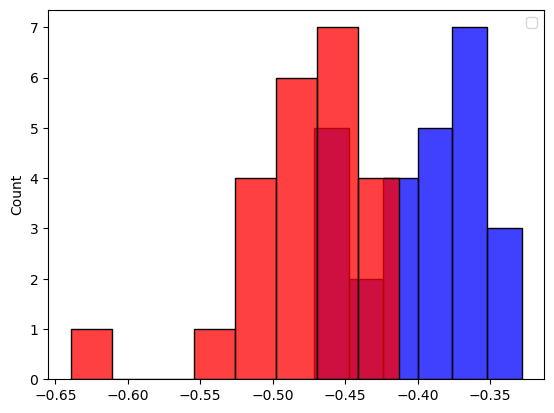

  epoch  :,001,   validation set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


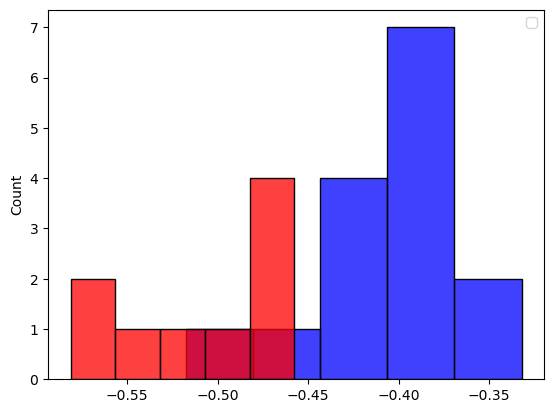

  epoch  :,001,   test set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


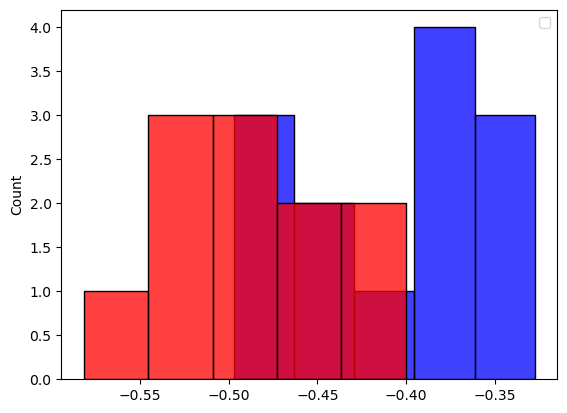

Epoch: 001, LR: 0.001000, Loss: 2.4579047, Val MAE: 0.4562724, Test MAE: 0.4966446
  elapsed time , 1.769113
  epoch  :002  train set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


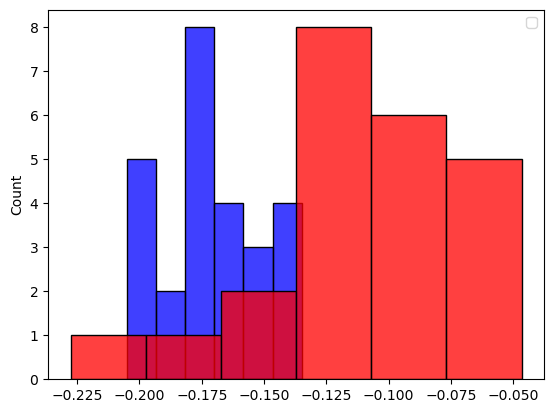

  epoch  :,002,   validation set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


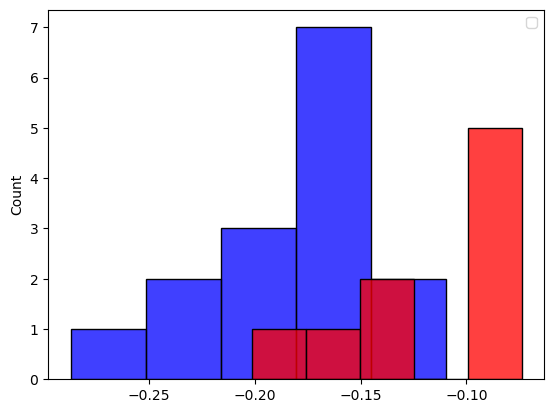

  epoch  :,002,   test set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


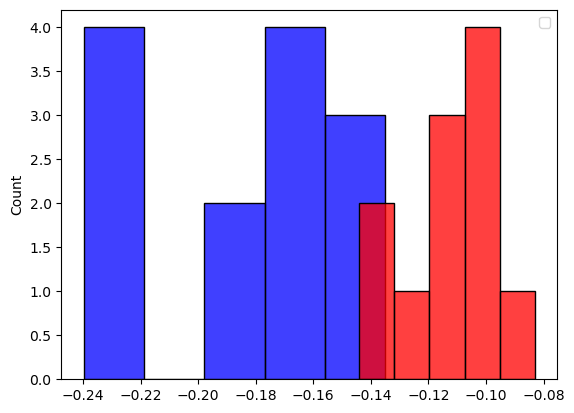

Epoch: 002, LR: 0.001000, Loss: 0.6704787, Val MAE: 0.4509683, Test MAE: 0.4709571
  elapsed time , 3.306850
  epoch  :003  train set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


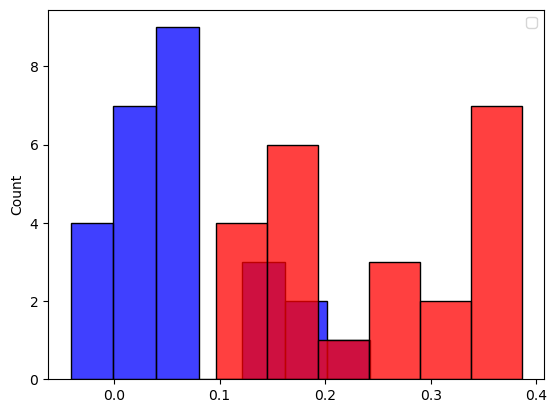

  epoch  :,003,   validation set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


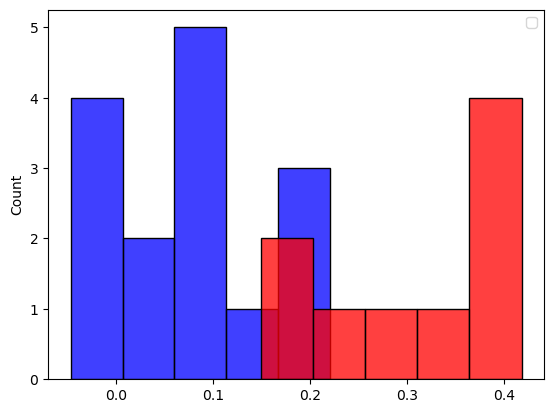

Epoch: 003, LR: 0.001000, Loss: 0.2601713, Val MAE: 0.4524367, Test MAE: 0.4709571
  elapsed time , 4.506812
  epoch  :004  train set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


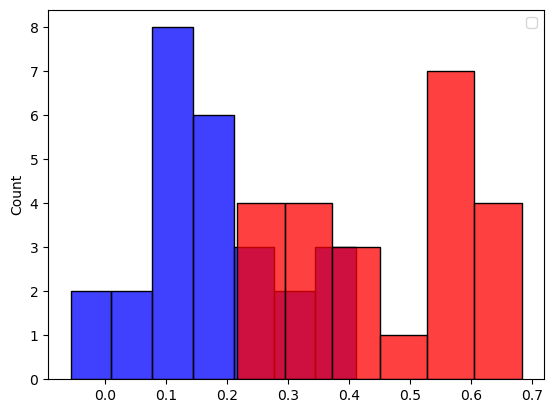

  epoch  :,004,   validation set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


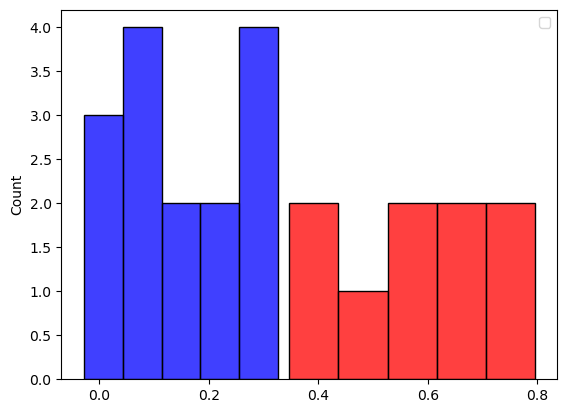

  epoch  :,004,   test set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


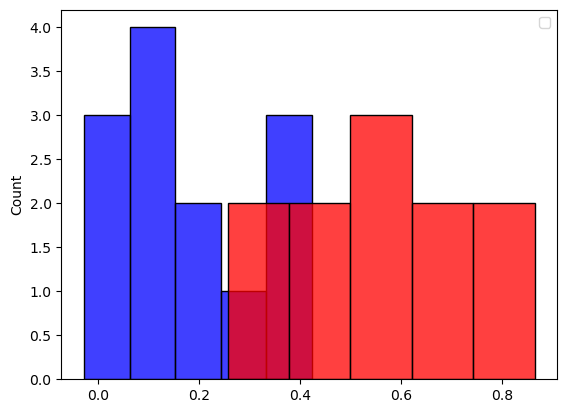

Epoch: 004, LR: 0.001000, Loss: 0.5115674, Val MAE: 0.4276569, Test MAE: 0.4139039
  elapsed time , 6.053493
  epoch  :005  train set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


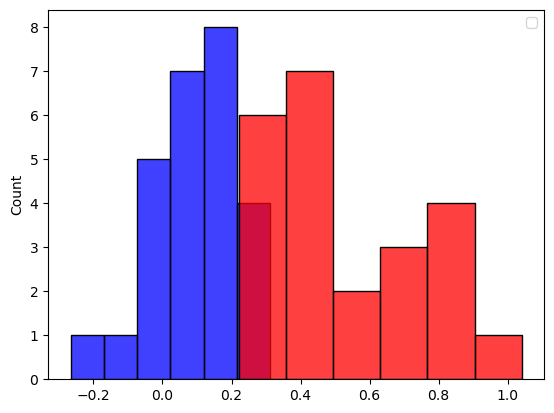

  epoch  :,005,   validation set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


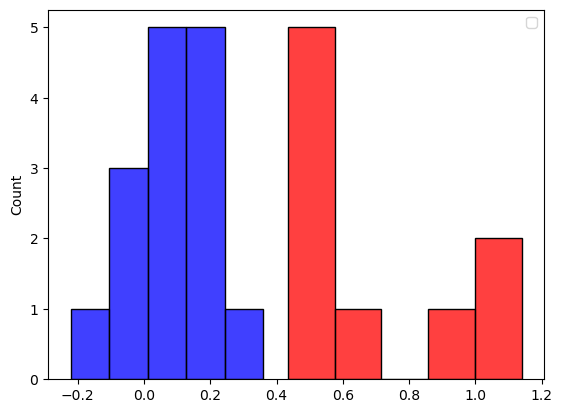

  epoch  :,005,   test set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


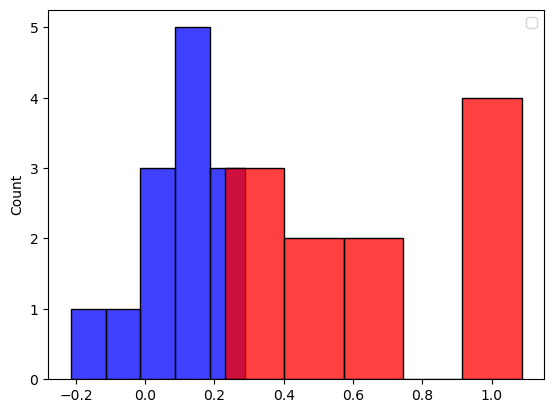

Epoch: 005, LR: 0.001000, Loss: 0.2327678, Val MAE: 0.3873044, Test MAE: 0.3781845
  elapsed time , 7.421853
  epoch  :006  train set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


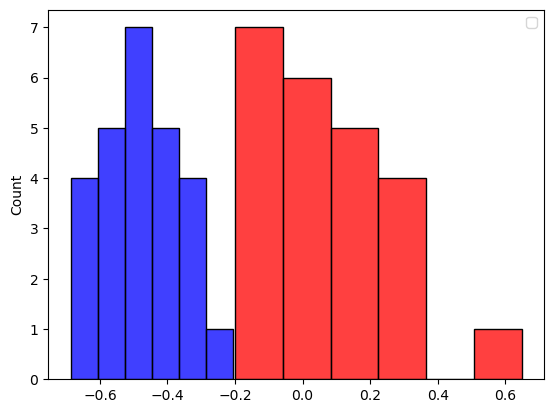

  epoch  :,006,   validation set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


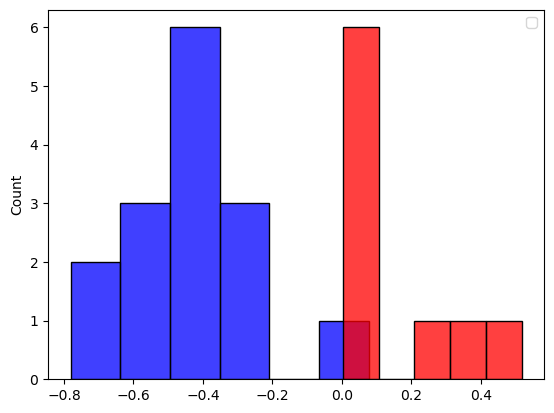

  epoch  :,006,   test set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


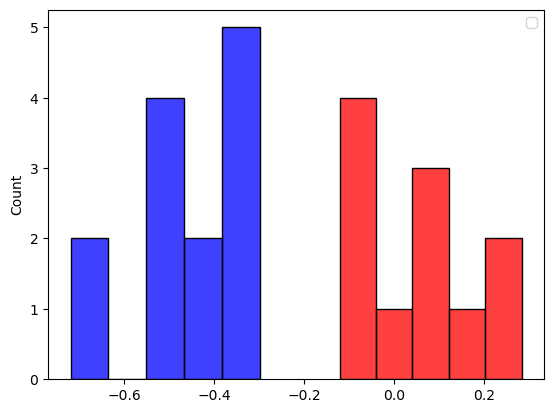

Epoch: 006, LR: 0.001000, Loss: 0.1753235, Val MAE: 0.3265290, Test MAE: 0.3585385
  elapsed time , 8.847921
  epoch  :007  train set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


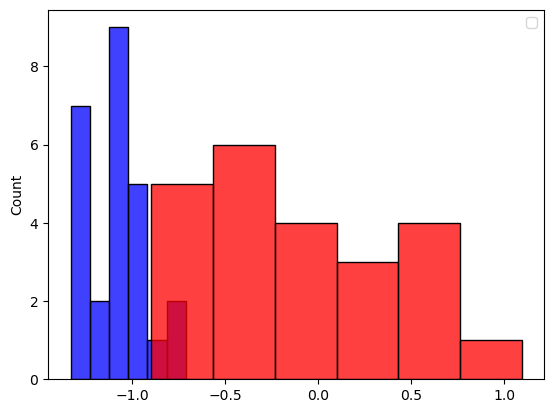

  epoch  :,007,   validation set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


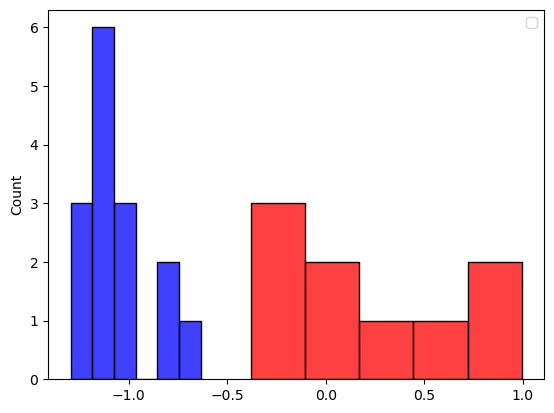

  epoch  :,007,   test set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


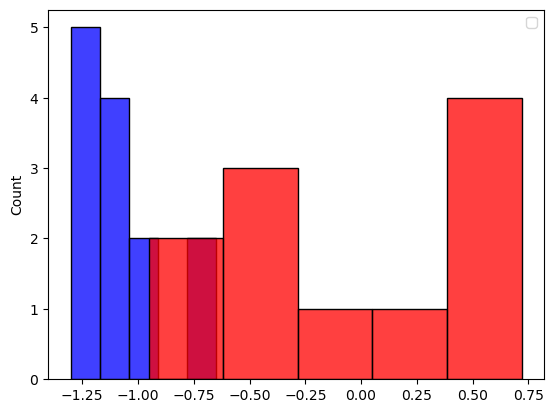

Epoch: 007, LR: 0.001000, Loss: 0.1322718, Val MAE: 0.2398422, Test MAE: 0.3323065
  elapsed time , 10.266058
  epoch  :008  train set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


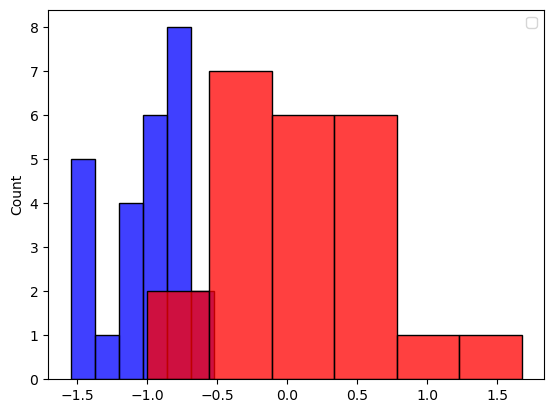

  epoch  :,008,   validation set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


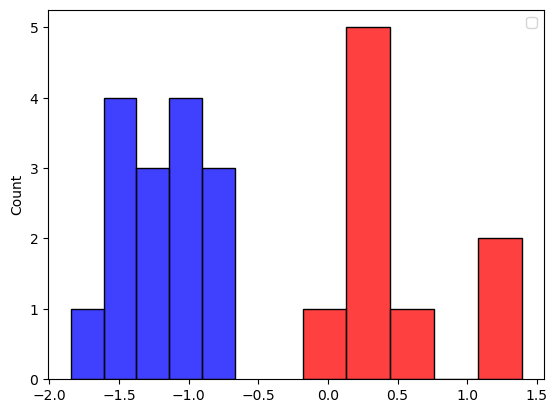

Epoch: 008, LR: 0.001000, Loss: 0.1894567, Val MAE: 0.2482452, Test MAE: 0.3323065
  elapsed time , 11.519666
  epoch  :009  train set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


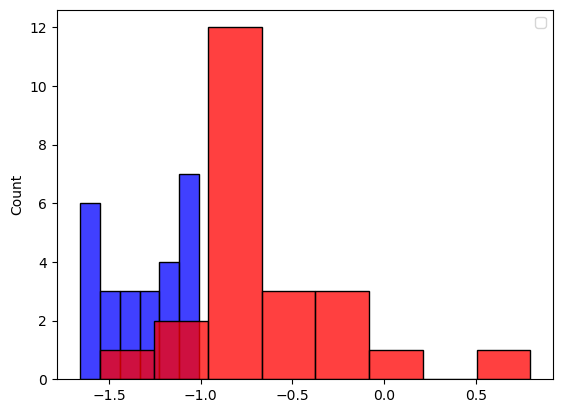

  epoch  :,009,   validation set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


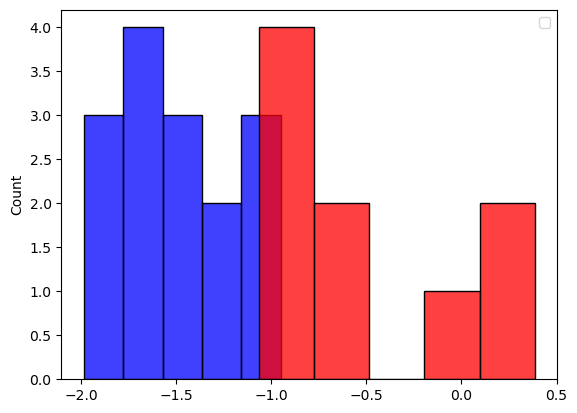

Epoch: 009, LR: 0.001000, Loss: 0.2326034, Val MAE: 0.4848489, Test MAE: 0.3323065
  elapsed time , 12.734375
  epoch  :010  train set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


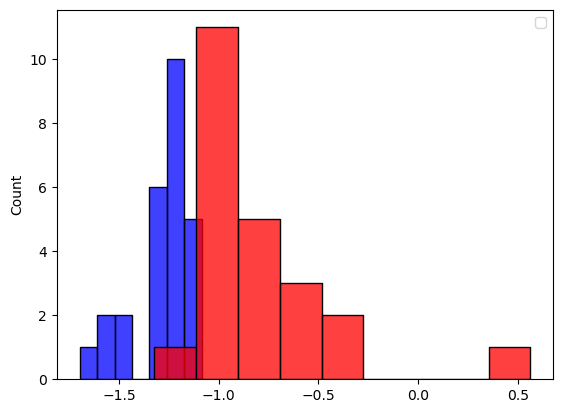

  epoch  :,010,   validation set 


/var/folders/sh/s3sz42dj4qz5yww8714w8x680000gp/T/ipykernel_53392/1810783567.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


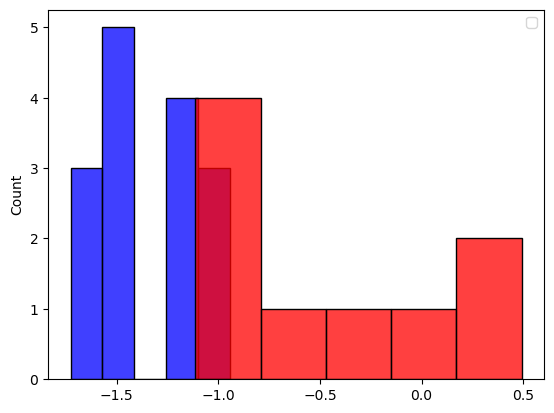

Epoch: 010, LR: 0.001000, Loss: 0.1126177, Val MAE: 0.4439902, Test MAE: 0.3323065
  elapsed time , 14.008039


In [ ]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=5, edge_dim=1, out_dim=1)
model_name = type(model).__name__
n_epochs = 100
print ('   evaluate model  ',model_name,'  n_epochs = ',n_epochs)
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=n_epochs
)
RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

In [ ]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

Super! Everything up to this point has already been covered in the lectures, and we hope that the practical so far has been a useful recap along with the acompanying code.

Now for the fun part, where you will be required to think what you have studied so far!

---
---
---

In [ ]:
tt = torch.Tensor([ 0.5392, -0.3957, -0.3674, -0.3929])
print (tt, len(tt))
path = '/home/para/GNN_loc/NEXT_GNN.pt'
print (model)
torch.save(model, path)

In [ ]:
path = '/home/para/GNN_loc/NEXT_GNN.pt'
print (model)
model = torch.load(path)
model.eval()

Let's now check that the sparse dataset is actually more sparse than the fully-connected dataset that we have been using throughout the practical:

In [ ]:
val_batch_sparse = next(iter(val_loader_sparse))
val_batch_dense = next(iter(val_loader))

# These two batches should correspond to the same molecules. Let's add a sanity check
assert torch.allclose(val_batch_sparse.y, val_batch_dense.y, atol=1e-4)

print(f"Number of edges in sparse batch {val_batch_sparse.edge_index.shape[-1]}. Number of edges in dense batch {val_batch_dense.edge_index.shape[-1]}")

Let's now compare the models under the two scenarios:

In [ ]:
sparse_results = {}
dense_results = RESULTS

In [ ]:
# ============ YOUR CODE HERE ==============
# Instantiate your models
models = [MPNNModel(), CoordMPNNModel(), InvariantMPNNModel(), FinalMPNNModel()]
# ==========================================

for model in models:
  model_name = type(model).__name__

  if model_name not in sparse_results:
    sparse_results[model_name] = run_experiment(
        model, 
        model_name, 
        train_loader_sparse,
        val_loader_sparse, 
        test_loader_sparse,
        n_epochs=100
    )
  
  if model_name not in dense_results:
    dense_results[model_name] = run_experiment(
        model, 
        model_name, 
        train_loader,
        val_loader, 
        test_loader,
        n_epochs=100
    )

In [ ]:
df_sparse = pd.DataFrame.from_dict(sparse_results, orient='index', columns=['Best val MAE', 'Test MAE', 'Train time', 'Train History'])
df_dense = pd.DataFrame.from_dict(dense_results, orient='index', columns=['Best val MAE', 'Test MAE', 'Train time'])
df_sparse['type'] = 'sparse'
df_dense['type'] = 'dense'
df = df_sparse.append(df_dense)

sns.set(rc={'figure.figsize':(10, 6)})
sns.barplot(x=df.index, y="Test MAE", hue="type", data=df);

# You might want to save and download this plot
# plt.savefig("comparison.png")
# files.download("comparison.png")